                Twitter Bot Detection using Random Forest and Naive Bayes classifier
             Project By : Girish Ganesh Prabhu (rrk310) and Rahul Ramesh Kumar (rrk310)


In [33]:
#Open Training File
import json
arr = []

with open('training/twitter_features_training.json') as data_file:
    randomdata = json.load(data_file)
    arr = randomdata['k']
rows = arr

                        Clean data and extract new features

In [34]:
import json
import random
import pandas as pd
import numpy as np
import re
from __future__ import division
import collections

hint = 'bot'

column_headers = [ 'favourites' , 'default_profile',  \
                  'followers' , 'friends'  , \
                  'verified' , \
                  'default_profile_image' , 'name_hint' ,  \
                  'name' , 'screenname' , 'description' , \
                  'has_extended_profile', 'location' ,'desc' ,  \
                  'totaltweets', 'loc', 'in_reply_to_status_id', \
                  'socialness', 'is_quote_status' , 'diversity' , \
                  'listed_count' , 'avgurls', 'avghashtags' ,'bot' ]

index = collections.OrderedDict()

#Fill a map with header to index
for i in range(0,len(column_headers)):
    index[column_headers[i]] = i

# get hint from name
def get_name_hint(s):
    if s is 0 :
        return 0
    return 1 if hint in s.lower().split() else 0

# get the diversity of characters
def lexical_diversity(text):
    diversity = 0
    if len(text) == 0:
        diversity =0
    else:
        diversity  = float(len(set(text))) / len(text)
    return round(diversity,2)

#calculates the lexical diversity for a user
def return_diversity(v):
    tot_div =0
    sz =0
    for key,value in v.items():
        if key == 'tweets':
            sz = sz+1
            for tweet in value:
                tw = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
                tot_div = tot_div + lexical_diversity(tw)
    
    if(sz != 0) :
        tot_div = tot_div/sz
    return tot_div

def get_diversity(row, v):
    row[index['diversity']] = return_diversity(v)

def get_desc_val(s):
    if s is 0:
        return 0
    if hint in s.lower():
        return 1
    return 0

def name_heuristic(name,desc):
    return name or desc

def digitize_loc(loc):
    if loc is 0:
        return 0
    if len(loc.strip()) >0 :
        return 1
    return 0

#need to trim after getting all the derived features
def trim_frame(df):
    del df['description']
    del df['name']
    del df['screenname']
    del df['location']
    del df['default_profile_image']
    del df['default_profile']
    del df['has_extended_profile']
    del df['avghashtags']
    del df['avgurls'] 
    del df['name_hint']
    del df['loc']
    #del df['followers']
    del df['socialness']
    #del df['is_quote_status']
    del df['diversity']
    
finalrow = []

def prep(df):
    df['default_profile_image'].fillna(0)
    df['description'].fillna('Empty Description')
    pd.isnull(df.location).astype(int)
    trim_frame(df)
    
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
#append rows to dataframe
def append_rows_to_list(v):
    row = [0]*len(column_headers)
    #get_diversity(row,v)
    
    for key,value in v.items():
        if key in index:
            if key == 'name' or key == 'screenname':                
                row[index['name_hint']] = get_name_hint(value) or row[index['name_hint']]
            else :
                row[index[key]] = value
    
    #row[index['name_hint']] = name_heuristic(row[index['name']], row[index['screenname']])
    row[index['desc']] = get_desc_val(row[index['description']])
    row[index['loc']] = digitize_loc(row[index['location']])
    
    return row

for k,v in rows[0].items():
    r = append_rows_to_list(v)
    if r is not None:
        finalrow.append(r)
        
df1 = pd.DataFrame(finalrow,columns=column_headers)
df1 = df1.sample(frac=1) #randomize
prep(df1)# todo call for test as well
df1.head(5)

,favourites,followers,friends,verified,desc,totaltweets,in_reply_to_status_id,is_quote_status,listed_count,bot
1086,0,16,2,0,0,7543,0,0,15,1
1486,1016,249,405,0,0,2144,21,37,3,0
355,5,1786,43,0,1,392,0,0,88,1
1333,1,95162,43,1,0,1,0,0,1143,0
182,2,23,0,0,0,99,87,0,1,1


                             Open Test File and create dataframe

In [35]:
#Open Test File
import json
import random
import pandas as pd
import numpy as np
import re
from __future__ import division

rows = []
with open('test/twitter_features_test.json') as data_file:
    randomdata = json.load(data_file)
    arr = randomdata['k']
rows = arr
finalrow = []

cnt = 0
for k,v in rows[0].items():
    r = append_rows_to_list(v)
    if r is not None:
        finalrow.append(r)

# create dataframe
df2 = pd.DataFrame(finalrow,columns=column_headers)
df2.apply(lambda row: (row['name'] or row['screenname']),axis=1)
prep(df2)
df2.head(5)

,favourites,followers,friends,verified,desc,totaltweets,in_reply_to_status_id,is_quote_status,listed_count,bot
0,1639,4535,1308,1,0,3061,59,23,111,NaN
1,304,298,780,0,0,629,3,6,10,NaN
2,13033,1046703,3018,1,0,3339,6,5,354,NaN
3,1150,468,522,0,0,66,23,2,18,NaN
4,213,191,68,0,1,696284,156,0,13,NaN


                               Using Naive Bayes Classifier

In [36]:
#Using Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB

array = df1.values
X = array[:,0:len(df1.columns)-1]
Y = array[:, len(df1.columns)-1]
X = X.astype(int)
Y = Y.astype(int)

data_train, data_test, target_train, target_test = train_test_split(X, Y, test_size=0.3, random_state=0)

kf = KFold(n_splits=10)
kf.get_n_splits(X)

model = BernoulliNB()

X = data_train
Y = target_train

scores =[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(X_train, y_train)
    predicted_rf1 = model.predict(X_test)
    target_names = ['bot', 'nonbot']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_rf1, pos_label=1)
    scores.append(metrics.auc(fpr, tpr))
    
model.fit(data_train, target_train)
predicted_nb = model.predict(data_test)
    
# #AUC 
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target_test, predicted_nb, pos_label=1)
print('TPR: ',tpr)
print('FPR: ',fpr)
print('AUC: ',metrics.auc(fpr, tpr))

#Precision, recall and F1
target_names = ['bot', 'nonbot']
print(classification_report(target_test, predicted_nb, target_names=target_names))
print('Accuracy using Naive Bayes Classifier is ' , np.mean(scores))

TPR:  [ 0.          0.67837838  1.        ]
FPR:  [ 0.          0.15631692  1.        ]
AUC:  0.761030730945
             precision    recall  f1-score   support

        bot       0.77      0.84      0.80       467
     nonbot       0.77      0.68      0.72       370

avg / total       0.77      0.77      0.77       837

Accuracy using Naive Bayes Classifier is  0.803925623498


                                Using Random Forest Classifier

In [38]:
# Using Random Forest Classifier
from pandas import DataFrame
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

array = df1.values
X = array[:,0:len(df1.columns)-1]
Y = array[:, len(df1.columns)-1]
X = X.astype(int)
Y = Y.astype(int)

data_train, data_test, target_train, target_test = train_test_split(X, Y, test_size=0.3, random_state=0)
num_trees = 200

model = RandomForestClassifier(n_estimators=num_trees , n_jobs=2, random_state = 42)

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn import metrics

X = data_train
Y = target_train

kf = KFold(n_splits=10)
kf.get_n_splits(X)
scores =[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(X_train, y_train)
    predicted_rf1 = model.predict(X_test)
    target_names = ['bot', 'nonbot']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_rf1, pos_label=1)
    score = metrics.auc(fpr, tpr)
    scores.append(score)
    
#Fit the training set
model.fit(data_train, target_train)
predicted_rf = model.predict(data_test)

# #AUC 
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target_test, predicted_rf, pos_label=1)
print('TPR: ',tpr)
print('FPR: ',fpr)
print('AUC: ',metrics.auc(fpr, tpr))

#Precision, recall and F1
target_names = ['bot', 'nonbot']
print(classification_report(target_test, predicted_rf, target_names=target_names))

print('Accuracy using Random Forest Classifier is ' , np.mean(scores))

TPR:  [ 0.          0.91891892  1.        ]
FPR:  [ 0.          0.07280514  1.        ]
AUC:  0.923056889866
             precision    recall  f1-score   support

        bot       0.94      0.93      0.93       467
     nonbot       0.91      0.92      0.91       370

avg / total       0.92      0.92      0.92       837

Accuracy using Random Forest Classifier is  0.906844596413


                                Ranking Feature Importance

Feature ranking:
1. feature 6 (0.211376)
2. feature 3 (0.206861)
3. feature 4 (0.120129)
4. feature 5 (0.091028)
5. feature 2 (0.083517)
6. feature 1 (0.075468)
7. feature 8 (0.075455)
8. feature 0 (0.070666)
9. feature 7 (0.065499)


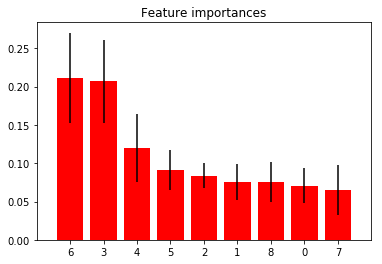

['favourites' 'followers' 'friends' 'verified' 'desc' 'totaltweets'
 'in_reply_to_status_id' 'is_quote_status' 'listed_count' 'bot']


In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
X = data_train
y = target_train
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

print(df1.columns.values)

                                    Classify Test Data

In [40]:
realarray = df2.values
predicted_rf_real = model.predict(realarray[:,0:len(df2.columns)-1])
np.savetxt("test_output/op.csv", predicted_rf_real, header='bot' ,delimiter=",", comments='')